In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import norm
import statsmodels.api as sm
from scipy.special import ndtri

In [73]:
# таблица данных об учениках и проведении теста
df = pd.read_csv('StudentsPerformance.csv')
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


In [74]:
df = df.rename(columns={'test preparation course':'test_preparation_course', 'math score':'math_score', 'reading score': 'reading_score','writing score':'writing_score'})

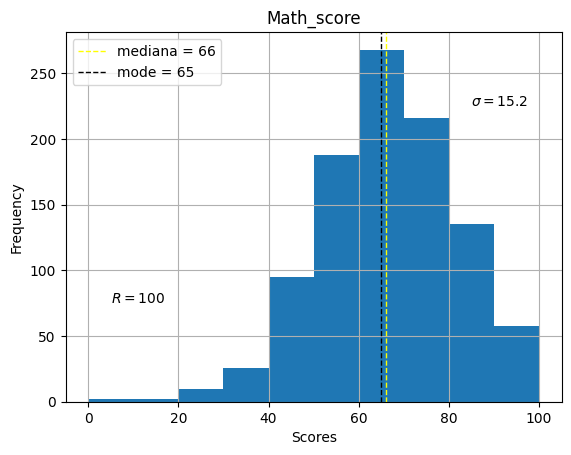

In [75]:
# построение результатов теста по математике
# анализ мер тенденции и мер изменчивости
fig, axs = plt.subplots()
axs.set_title('Math_score')
axs.set_xlabel('Scores')
axs.set_ylabel('Frequency')
axs.axvline(df.math_score.median(), color='yellow', linestyle='dashed', linewidth=1, label = f'mediana = {int(df.math_score.median())}')
#axs.axvline(df.math_score.mean(), color='yellow', linestyle='dashed', linewidth=1, label = 'mean')
axs.axvline(df.math_score.mode()[0], color='black', linestyle='dashed', linewidth=1, label = f'mode = {df.math_score.mode()[0]}')
df.math_score.hist(ax=axs)
plt.legend(loc='upper left')
plt.text(85, 225, f'$\sigma = {round(df.math_score.std(),1)}$')
plt.text(5, 75, f'$R = {round(df.math_score.max() - df.math_score.min(),1)}$');

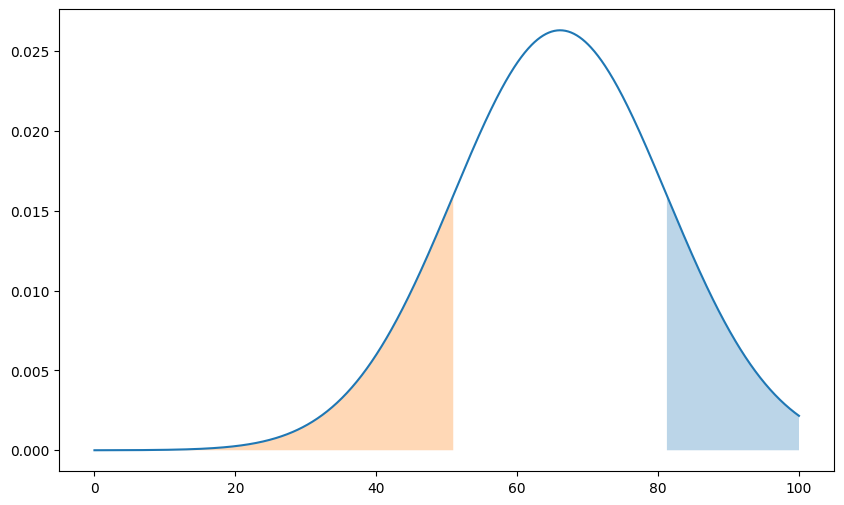

In [80]:
# доверительный интервал для результатов по математике
plt.figure(figsize = (10,6))
 
mean, std  = df.math_score.mean(), df.math_score.std()
# создадим пространство из 1000 точек в диапазоне +/- трех СКО от среднего значения
x = np.linspace(df.math_score.min(), df.math_score.max(), 1000)
 
# рассчитаем значения по оси y с помощью метода .pdf()
# т.е. функции плотности распределения
f = norm.pdf(x, mean, std)
 
# и построим график
plt.plot(x, f)
 
# дополнительно создадим точки на оси х для закрашенной области
px_1 = np.linspace(mean + std, df.math_score.max(), 1000)
px_2 = np.linspace(df.math_score.min(), mean - std, 1000)
 
# и заполним в пределах этих точек по оси x пространство
# от кривой нормального распределения до оси y = 0
plt.fill_between(px_1, norm.pdf(px_1, mean, std), alpha = 0.3)
plt.fill_between(px_2, norm.pdf(px_2, mean, std), alpha = 0.3)
 
# выведем оба графика
plt.show()

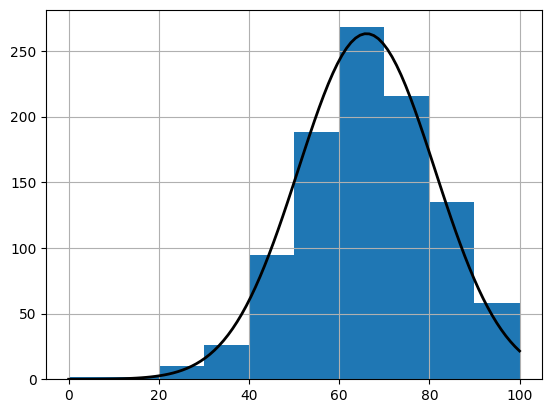

In [ ]:
# проверка данных на нормальность по гистограмме
mu, std = norm.fit(df.math_score.head(999))
x = np.linspace(0, 100, 100)
p = norm.pdf(x, mu, std) # функция плотности вероятности
df.math_score.hist()
plt.plot(x, p*10**4, 'k', linewidth=2);


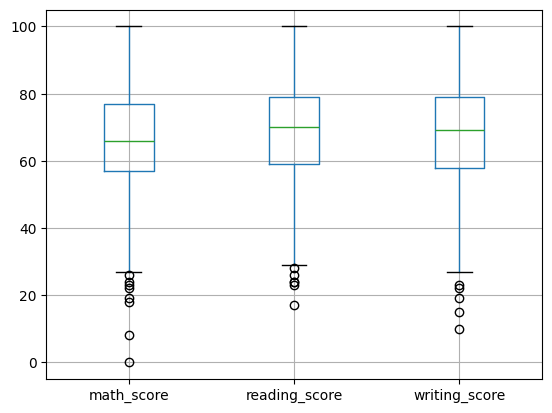

In [6]:
# надо про выбросы вспонить и подумать над оформлением.
# построение результатов тестов на boxplot. Хуже всего написали ученики написали математику
df.boxplot(column=['math_score', 'reading_score', 'writing_score']);

In [101]:
# проверка нормальности данных по графику Q-Q-plot
df = df[['gender','math_score']].sort_values(by='math_score',ascending=True).reset_index(drop=True)
df['count'] = df.index + 1
df['comparison_points'] = (df['math_score'] - df['math_score'].mean())\
                          /df['math_score'].std(ddof=0) # t-тест
df['real_normal'] = ndtri(df['count']/df.shape[0]) #расчёт плотности вероятности

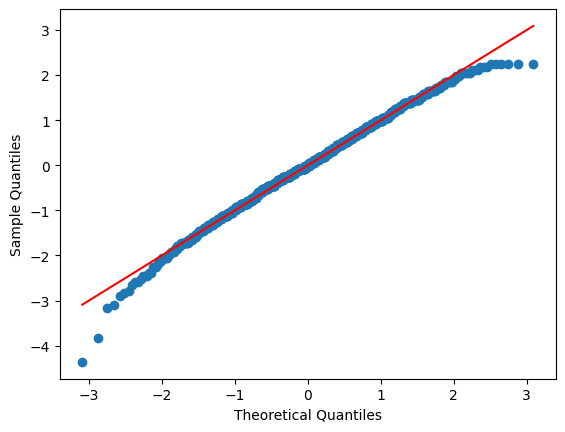

In [103]:
# отрицательный склон
plt.scatter(df['real_normal'],df['comparison_points'])
plt.plot(df['real_normal'],df['real_normal'], color='red')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles");